# Program - Plot DYCOMS domain-avg LWP time series in ERA5 and TaiESM1 hindcast simulations


In [1]:
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc
#import read_data as read_data   ## on GFDL PP/AN
import read_data_big as read_data    ## on my Mac

#--- silence dask large chunk and silence the warning.
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

ERROR 1: PROJ: proj_create_from_database: Open of /lfs/opt/anaconda3/share/proj failed


## Read ERA5, and TaiESM hindcast variables

### read_era5_var

#### convert_time_to_yyyymmdd_hhmmss

In [73]:
from datetime import datetime

def convert_time_to_yyyymmdd_hhmmss(dataset):
    # Read the time variable
    time_var = dataset['time']

    # Get the units and the calendar attributes
    time_units = time_var.attrs['units']
    time_calendar = time_var.attrs.get('calendar', 'gregorian')

    # Convert the time variable to datetime objects using netCDF4 utilities
    time_values = xr.coding.times.decode_cf_datetime(time_var, units=time_units, calendar=time_calendar)

    # Convert numpy.datetime64 objects to datetime.datetime objects and format them to YYYY-MM-DD-HH-MM-SS
    time_str = [np.datetime_as_string(dt, unit='s') for dt in time_values]
    time_str = [dt.replace('T', '-') for dt in time_str]

    return time_str

datapath_era5 = "/lfs/home/yihsuanc/data/data.ERA5/"
fname = datapath_era5+"ERA5-2001July-toa_sw.nc"
da_era5 = xr.open_dataset(fname, decode_cf=False)  # ERA5 variables are in short format
time_str = convert_time_to_yyyymmdd_hhmmss(da_era5)
#print(time_str[216:240])

In [74]:
def read_era5_var (date, 
                   varname="tclw", datapath_era5 = "/lfs/home/yihsuanc/data/data.ERA5/",
                   region="DYCOMS"):

    #--- read ERA5 dataset
    fname = datapath_era5+"ERA5-2001July-toa_sw.nc"
    da_era5 = xr.open_dataset(fname, decode_cf=False)  # ERA5 variables are in short format

    if (date == "2001-07-11"):
        tt_start = 240 ; tt_end = 264
    elif (date == "2001-07-10"):
        tt_start = 216 ; tt_end = 240
    else:
        error_msg = f"date [{date}] is supported"
        raise ValueError(error_msg)

    #--- read ERA5 variable
    var1_era5 = da_era5.get(varname)[tt_start:tt_end,:,:]  #.mean("time")        
    var1_era5 = (var1_era5*var1_era5.scale_factor + var1_era5.add_offset)       
    var_era5 = var1_era5.copy()
    
    #--- rename ERA5 coordinate names
    var_era5 = var_era5.rename({'longitude':'lon', 'latitude':'lat'})
    var_era5 = var_era5.sortby('lat', ascending=True)
    
    #--- get regional average
    var_era5_ijavg = yhc.get_area_avg(var_era5, region)
    #print(var_era5_ijavg)
    #var_era5_ijavg = var_era5_ijavg[0:720]  # July 1-30
    
    return var_era5_ijavg

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    #varname_am4 = "swcre_toa"
    varname_am4 = "LWP"
    date = "2001-07-10"
    #var_era5 = read_era5_var(varname="tclw", date=date)
    var_era5 = read_era5_var(date=date)
#var_era5

    #print(len(var_era5.values))
    #print(var_era5.values)
    
    #choice="era5_2001July_toa_sw"
    #da_era5 = read_data.read_era5_data(choice)

    #da_era5
    #print(var_era5)

### Read TaiESM hindcast simulation data

In [76]:
def read_TaiESM1_hindcast_var (dayN, date, 
                               varname1="TGCLDLWP",
                               region="DYCOMS",
                               choice="TaiESM1_July01_30_2d_1hr",varname="FSNTOA"):

    if (date == "2001-07-11"):
        tt_start = 240 ; tt_end = 264
    elif (date == "2001-07-10"):
        tt_start = 216 ; tt_end = 240
    else:
        error_msg = f"date [{date}] is supported"
        raise ValueError(error_msg)
    
    da_taiesm = read_data.read_TaiESM1_hindcast_data(choice, dayN)
    var1 = da_taiesm.get(varname1)[tt_start:tt_end, :, :]  #.mean("time")

    #--- get regional average
    var1_ijavg = yhc.get_area_avg(var1, region)
    return var1_ijavg

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    date = "2001-07-10"
    var2_taiesm = read_TaiESM1_hindcast_var(date=date, dayN=5)

#var2_taiesm

### Read both ERA5 and TaiESM hindcast simulation data

In [95]:
def read_ERA5_TaiESM1_hindcast_var (date):
    var_era5 = read_era5_var(date=date)
    var_taiesm_day1 = read_TaiESM1_hindcast_var(date=date, dayN=1)
    var_taiesm_day3 = read_TaiESM1_hindcast_var(date=date, dayN=3)
    var_taiesm_day5 = read_TaiESM1_hindcast_var(date=date, dayN=5)

    return var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5

#-----------
# do_test
#-----------

do_test=True
#do_test=False

if (do_test):
    date = "2001-07-11"
    dayN = 5

    var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5 = read_ERA5_TaiESM1_hindcast_var(date=date)

In [109]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def plot_time_series(date, 
                     var1, 
                     var_taiesm_day1, var_taiesm_day3, var_taiesm_day5,
                     ):
    # Generate time values from 0 to 23
    time_values = np.arange(0, 24)

    # Plotting the time series
    plt.figure(figsize=(10, 6))

    plt.plot(time_values, var1.values, label='ERA5', color='black', marker='o')
    plt.plot(time_values, var_taiesm_day1.values, label=f'TaiESM1 day 1', color='orange', marker='o')
    plt.plot(time_values, var_taiesm_day3.values, label=f'TaiESM1 day 3', color='cyan', marker='o')
    plt.plot(time_values, var_taiesm_day5.values, label=f'TaiESM1 day 5', color='red', marker='o')

    plt.xlabel(f'UTC on {date}')
    plt.ylabel('LWP (kg/m2)')
    plt.title(f'LWP hourly time series on {date}')
    plt.legend()
    plt.grid(True)
    plt.minorticks_on()

    # Show the plot
    plt.show()

#date = "2001-07-11"
#dayN = 5

#var_era5, var_taiesm = read_ERA5_TaiESM1_hindcast_var(date=date, dayN=dayN)


#plot_time_series(var_era5, var_taiesm,
#                date=date, dayN=dayN)
#

## Plot

### 2001-07-10

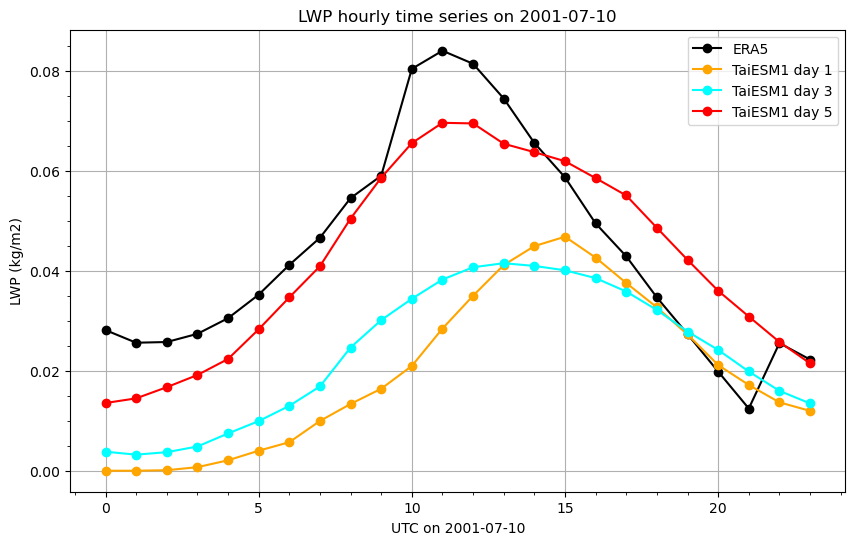

In [110]:
date = "2001-07-10"
var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5 = read_ERA5_TaiESM1_hindcast_var(date=date)
plot_time_series(date, var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5)

### 2001-07-11

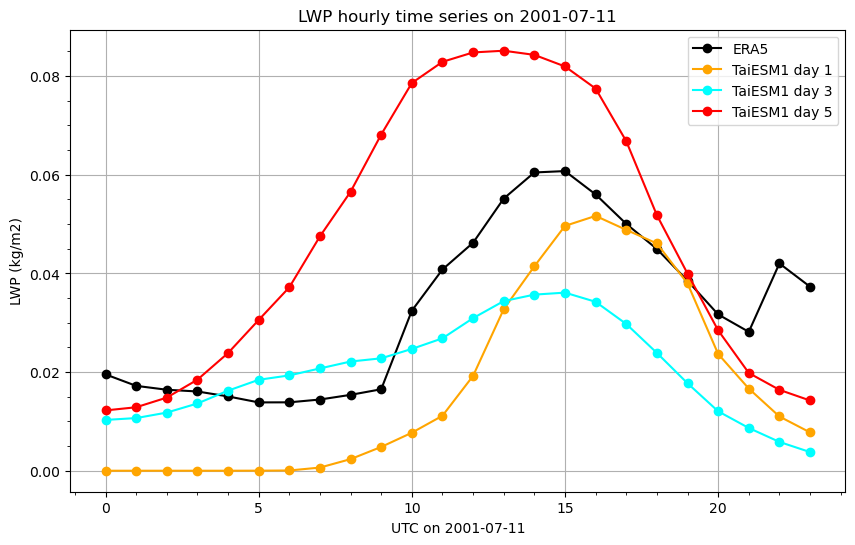

In [111]:
date = "2001-07-11"
var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5 = read_ERA5_TaiESM1_hindcast_var(date=date)
plot_time_series(date, var_era5, var_taiesm_day1, var_taiesm_day3, var_taiesm_day5)